# The Palatable Diet Problem  

**Problem Description.** The Diet Problem is the first large-scale optimization problem to be solved with the Simplex algorithm by Jack Laderman in [1947](https://www.mpi-inf.mpg.de/fileadmin/inf/d1/teaching/winter18/Ideen/Materialien/Dantzig-Diet.pdf). The basic formulation of this problem consists of minimizing the cost of a food basket while meeting the specified nutrient requirements. In this notebook, we solve The Palatable Diet Problem (TPDP), where the basic model is extended with a constraint on the food basket palatability. An explicit formula of the palatability constraint is unknown, but we have data on several food baskets and the respective palatability score. First, we define a conceptual model with the *known constraint*. Then, OptiCL is used to learn and embed the palatability constraint.  
(*TPDP is part of a larger optimization problem which simultaneously  optimizes  the  food  basket  to  be  delivered,  the  sourcing  plan,  the  delivery  plan, and  the  transfer  modality  of  a  month-long  food  supply in a Wolrd Food Program setting ([Maragno et al., 2021])*).

<font color='#808080'>**Objective function:** minimize the total cost of the food basket.</font>  
$\min_{\boldsymbol{x}} c^\top \boldsymbol{x}$

*subject to* 

<font color='#808080'>**Nutritional constraints:** for each nutrient $l\in\mathcal{L}$, at least meet the minimum required level.</font>  
$ \sum_{k \in \mathcal{K}} nutval_{kl} x_{k} \geq nutreq_{l}, \ \ \ \forall l\in\mathcal{L},$   
<font color='#808080'>**Palatability constraints:** the food basket palatability has to be at least equal to $t$.</font>  
$ y \geq t,$  
<font color='#808080'>**Learned predictive model:** the palatability is defined using a predictive model.</font>  
$ y = \hat{h}(\boldsymbol{x}),$   
<font color='#808080'>**Non negativity constraints.**</font>  
$ x_{k} \geq 0, \ \ \ \forall k \in \mathcal{K}.$  

In [1]:
import pandas as pd
import numpy as np
import time
import sys
import os
sys.path.append(os.path.abspath('../../src'))  # TODO: has to be changed
import opticl
from pyomo import environ
from pyomo.environ import *
import embed_mip as em
from imp import reload
import matplotlib.pyplot as plt

### Data Loading  
**nutr_val**: nutritional values for each of the 25 foods  
**nutr_req**: 11 nutrition requirements  
**cost_p**: vector of procurement costs  
**dataset**: dataframe of food basket instances and relative palatability score

In [2]:
nutr_val = pd.read_excel('../WFP/processed-data/Syria_instance.xlsx', sheet_name='nutr_val', index_col='Food')
nutr_req = pd.read_excel('../WFP/processed-data/Syria_instance.xlsx', sheet_name='nutr_req', index_col='Type')
cost_p = pd.read_excel('../WFP/processed-data/Syria_instance.xlsx', sheet_name='FoodCost', index_col='Supplier').iloc[0,:]
dataset = pd.read_csv('../WFP/processed-data/WFP_palatability_robustness.csv').sample(frac=1)

nutr_val.drop(['Salt','Sugar'], axis=0, inplace = True)
nutr_val.drop(['Iodine(ug)'], axis=1, inplace = True)
nutr_req.drop(['Iodine(ug)'], axis=1, inplace = True)
dataset.drop(['Salt','Sugar'], axis=1, inplace=True)
dataset = dataset.round(4)
dataset.to_csv('../WFP/processed-data/WFP_dataset_processed.csv', index=False)
dataset

,Beans,Bulgur,Cheese,Fish,Meat,CSB,Dates,DSM,Milk,Lentils,...,Sorghum,Soya-fortified bulgur wheat,Soya-fortified maize meal,Soya-fortified sorghum grits,Soya-fortified wheat flour,Oil,Wheat,Wheat flour,WSB,label
3036,0.8246,0.0000,0.0157,0.0,0.0000,0.0000,0.0,0.1448,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.053,0.2080,0.0848,4.9065,0.8448,0.4202
770,0.8998,0.0000,0.0000,0.0,0.4147,0.0000,0.0,0.1816,0.0000,0.0000,...,0.0000,0.1835,0.0000,0.0000,0.000,0.1634,5.6190,0.0000,0.7000,0.1109
284,0.0000,1.6627,0.1446,0.0,0.0000,0.6303,0.0,0.4024,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.000,0.1728,0.0000,0.0000,0.0000,0.4545
2369,0.3247,5.6241,0.4102,0.0,0.1491,0.0000,0.0,0.0204,0.0108,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.000,0.1601,0.0000,0.0000,0.8376,0.0847
1699,0.8149,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.1781,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.000,0.3801,1.2954,2.8800,0.7513,0.5103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1396,0.7633,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.3199,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.000,0.2386,0.4705,3.7605,0.6170,0.8759
2943,0.7837,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.1394,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0481,0.000,0.3158,0.1876,5.7215,0.8509,0.3341
378,0.9442,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0358,0.0000,0.0000,...,2.4636,0.0000,0.0000,0.0000,0.000,0.1721,1.8467,0.8427,0.8666,0.1865
2396,0.7294,0.0000,0.2161,0.0,0.0000,0.7060,0.0,0.3625,0.0000,0.2681,...,0.0000,0.0000,0.0614,0.0000,0.000,0.1910,0.0000,0.0000,0.0000,0.1197


# OptiCL: Optimization with Constraint Learning

## Step 1: Conceptual Model

In [39]:
def init_conceptual_model(cost):
    N = list(nutr_val.index)  # foods
    M = nutr_req.columns  # nutrient requirements

    model = ConcreteModel('TPDP')

    '''
    Decision variables
    '''
    model.x = Var(N, domain=NonNegativeReals)  # variables controlling the food basket

    '''
    Objective function.
    '''
    def obj_function(model):
        return sum(cost[food].item()*model.x[food] for food in N)

    model.OBJ = Objective(rule=obj_function, sense=minimize)

    '''
    Nutrients requirements constraint.
    '''
    def constraint_rule1(model, req):
        return sum(model.x[food] * nutr_val.loc[food, req] for food in N) >= nutr_req[req].item()
#     model.Constraint1 = Constraint(M, rule=constraint_rule1)
    
    return model

## Step 2: Data Processing

In [4]:
y = dataset['label']
X = dataset.drop(['label'], axis=1, inplace=False)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

## Part 3: Learn the predictive models
'alg_list' specifies the list of algorithms that you will consider in the training pipeline. If you have the InterpretableAI license, you can include **iai** (Optimal Trees with Hyperplanes) or **iai-single** (Optimal Trees with single feature splits) in the list. If using IAI, you must specify the metric as 'r2'. Otherwise, the default metric is 'neg_squared_mse'.

In [5]:
version = 'TR_test_v1'
alg_list = ['cart']
outcome_list = {'opticl_palatability': {'outcome_type': ['constraint', None], 'task_type': 'continuous', 'alg_list':alg_list, 
                                   'X_train':X_train, 'y_train':y_train, 'X_test':X_test, 'y_test':y_test}}

In [6]:
performance = pd.DataFrame()

if not os.path.exists('results/'):
    os.makedirs('results/')

for outcome in outcome_list.keys():
    print(f'Learning a constraint for {outcome}')
    
    alg_list = outcome_list[outcome]['alg_list']
    task_type = outcome_list[outcome]['task_type']
    for alg in alg_list:
        print(f'Training {alg}')
        X_train = outcome_list[outcome]['X_train']
        y_train = outcome_list[outcome]['y_train']
        X_test = outcome_list[outcome]['X_test']
        y_test = outcome_list[outcome]['y_test']
        
        if not os.path.exists('results/%s/' % alg):
            os.makedirs('results/%s/' % alg)
        s = 0

        ## Run shallow/small version of RF
        alg_run = 'rf_shallow' if alg == 'rf' else alg

        m, perf = opticl.run_model(X_train, y_train, X_test, y_test, alg_run, outcome, task = task_type,
                               seed = s, cv_folds = 5, 
                               # metric = 'r2',
                               save = False
                              )

        ## Save model
        constraintL = opticl.ConstraintLearning(X_train, y_train, m, alg)
        constraint_add = constraintL.constraint_extrapolation(task_type)
        constraint_add.to_csv('results/%s/%s_%s_model.csv' % (alg, version, outcome), index = False)

        ## Extract performance metrics
        try:
            perf['auc_train'] = roc_auc_score(y_train >= threshold, m.predict(X_train))
            perf['auc_test'] = roc_auc_score(y_test >= threshold, m.predict(X_test))
        except: 
            perf['auc_train'] = np.nan
            perf['auc_test'] = np.nan

        perf['seed'] = s
        perf['outcome'] = outcome
        perf['alg'] = alg
        perf['save_path'] = 'results/%s/%s_%s_model.csv' % (alg, version, outcome)
        
            
        perf.to_csv('results/%s/%s_%s_performance.csv' % (alg, version, outcome), index = False)
        
        performance = performance.append(perf)
        print()
print('Saving the performance...')
performance.to_csv('results/%s_performance.csv' % version, index = False)
print('Done!')

Learning a constraint for opticl_palatability
Training cart
------------- Initialize grid  ----------------
------------- Running model  ----------------
Algorithm = cart, metric = None
saving... results/cart_opticl_palatability_trained.pkl
------------- Model evaluation  ----------------
-------------------training evaluation-----------------------
Train MSE: 0.012587460051174013
Train R2: 0.815819801981194
-------------------testing evaluation-----------------------
Test MSE: 0.017952064209395387
Test R2: 0.7395678353529131

Saving the performance...
Done!


## Step 4: Predictive model selection and Optimization

In [7]:
version = 'TR_test_v1'
performance = pd.read_csv('results/%s_performance.csv' % version)
performance.dropna(axis='columns')

,save_path,seed,cv_folds,task,parameters,best_params,valid_score,train_score,train_r2,test_score,test_r2,outcome,alg
0,results/cart/TR_test_v1_opticl_palatability_mo...,0,5,continuous,"{'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'min_...","{'max_depth': 10, 'max_features': 1.0, 'min_sa...",-0.01842,0.012587,0.81582,0.017952,0.739568,opticl_palatability,cart


In [8]:
model_master = opticl.model_selection(performance, outcome_list)
model_master

               outcome model_type  \
0  opticl_palatability       cart   

                                           save_path        task  objective  
0  results/cart/TR_test_v1_opticl_palatability_mo...  continuous          0  


,outcome,model_type,save_path,task,objective
0,opticl_palatability,cart,results/cart/TR_test_v1_opticl_palatability_mo...,continuous,0


In [9]:
def check_palatability(solution): 
    min_, max_ = 72.401310506, 430.8811249455  #### based on the dataset
    group = {0: [1, 10, 13, 11, 14, 20, 21], 1: [0, 6, 9, 12], 2: [19], 3: [5, 22, 15, 16, 17, 18], 4: [2, 3, 4, 7, 8]}
    coeff = [1, 5.7, 16, 4.4, 6.6]
    opt = [400, 130/2, 55/2, 45, 30]
    
    sol_score = np.round(np.sqrt(sum((coeff[i]*(sum(solution[j] for j in group[i])-opt[i]))**2 for i in range(5))), 10)
    norm_score = 1-(sol_score - min_)/(max_ - min_)
    return norm_score

In [10]:
model_master = opticl.model_selection(performance, outcome_list)
model_master[['lb', 'ub', 'SCM_counterfactuals', 'features', 'trust_region', 'dataset_path',
              'clustering_model', 'max_violation', 'enlargement', 'var_features', 'contex_features']] = None

model_master.loc[0, 'lb'] = 0.6
model_master.loc[0, 'ub'] = None
model_master.loc[0, 'SCM_counterfactuals'] = None
model_master.at[0, 'features'] = [col for col in X.columns]
model_master.loc[0, 'trust_region'] = True
model_master.loc[0, 'dataset_path'] = '../WFP/processed-data/WFP_dataset_processed.csv'
model_master.loc[0, 'clustering_model'] = None
model_master.loc[0, 'max_violation'] = None
model_master.at[0, 'var_features'] = [col for col in X.columns]
model_master.at[0, 'contex_features'] = {}  # example: {'contextual_feat_name_1': 1, contextual_feat_name_2': 5}

# enlargement option: 0-No enlargement, 1-CH enlargement; 
# enlargement constraint:  0-constraint, 1-objective penalty; 
# constraint ub/penalty multiplier
model_master.at[0, 'enlargement'] = [1, 0, 0] 
model_master

               outcome model_type  \
0  opticl_palatability       cart   

                                           save_path        task  objective  
0  results/cart/TR_test_v1_opticl_palatability_mo...  continuous          0  


,outcome,model_type,save_path,task,objective,lb,ub,SCM_counterfactuals,features,trust_region,dataset_path,clustering_model,max_violation,enlargement,var_features,contex_features
0,opticl_palatability,cart,results/cart/TR_test_v1_opticl_palatability_mo...,continuous,0,0.6,None,None,"[Beans, Bulgur, Cheese, Fish, Meat, CSB, Dates...",True,../WFP/processed-data/WFP_dataset_processed.csv,None,None,"[1, 0, 0]","[Beans, Bulgur, Cheese, Fish, Meat, CSB, Dates...",{}


In [ ]:
reload(em)
solution_info = {}

epsilon = [0.00, 0.010, 0.050, 0.075] + list(np.round(np.logspace(-1,-0.096910013,15, base=10), 2))
N = len(epsilon)
M = 5
E0 = 0
E1 = .8
# epsilon = np.round(np.linspace(E0,E1,N), 4)

for i, eps in enumerate(epsilon):
    for j in range(M):
        np.random.seed(j)  #########################
        model_master.at[0, 'enlargement'] = [1, 0, eps] 
        cost = pd.DataFrame([np.round(np.random.rand(23), 4)], columns=X.columns)
        conceptual_model = init_conceptual_model(cost)
        final_model = em.optimization_MIP(conceptual_model, model_master)
        opt = SolverFactory('gurobi')
        print('---------------------Solving the optimization problem---------------------')
        results = opt.solve(final_model) 
        solution = []
        for food in list(nutr_val.index):
            solution.append(np.round(value(final_model.x[food])*100, 6))
        solution_info[i,j] = {'solution': solution, 'obj': value(final_model.OBJ), 'real_pal': check_palatability(solution), 'pred_pal': value(final_model.y['opticl_palatability'])}
#         print('###################################################################################')
#         print('avg real palatability', [np.mean([solution_info[ii,jj]['real_pal'] for jj in range(j)]) for ii in range(i)])
#         print('avg objective value', [np.mean([solution_info[ii,jj]['obj'] for jj in range(j)]) for ii in range(i)])
#         print('avg pred palatability', [np.mean([solution_info[ii,jj]['pred_pal'] for jj in range(j)]) for ii in range(i)])
#         print('###################################################################################')

Generating constraints for the trust region using 4049 samples.
The l1 norm is used for the enlarged CH trust region
The trust region is being enlarged with a constraint upper bounded by: 0.0.
... Trust region defined.
Embedding constraints for opticl_palatability
---------------------Solving the optimization problem---------------------
Generating constraints for the trust region using 4049 samples.
The l1 norm is used for the enlarged CH trust region
The trust region is being enlarged with a constraint upper bounded by: 0.0.
... Trust region defined.
Embedding constraints for opticl_palatability
---------------------Solving the optimization problem---------------------
Generating constraints for the trust region using 4049 samples.
The l1 norm is used for the enlarged CH trust region
The trust region is being enlarged with a constraint upper bounded by: 0.0.
... Trust region defined.
Embedding constraints for opticl_palatability
---------------------Solving the optimization problem--

In [ ]:
lb = model_master.loc[0, 'lb']
import pickle
filename = f'LB_{lb}_{alg}_eps{E0}-{E1}_N{N}_M{M}.pkl'
with open(filename, 'wb') as f:
    pickle.dump(solution_info, f)

### Plot mean objective value and mean real palatability wrt epsilon

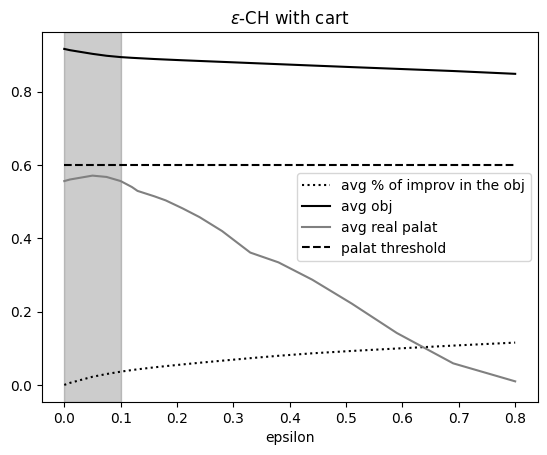

In [38]:
mean_obj = [np.median([solution_info[i,j]['obj'] for j in range(M)]) for i in range(N)]
improvement_obj = [(np.mean([solution_info[0,j]['obj'] for j in range(M)]) - np.mean([solution_info[i,j]['obj'] for j in range(M)]))/np.mean([solution_info[0,j]['obj'] for j in range(M)]) for i in range(N)]
mean_real_pal = [np.median([solution_info[i,j]['real_pal'] for j in range(M)]) for i in range(N)]
violations_pal = [np.sum([1 if solution_info[i,j]['real_pal'] < lb else 0 for j in range(M)])/M  for i in range(N)]

plt.plot(epsilon, improvement_obj, color='black', label='avg % of improv in the obj', linestyle='dotted')
plt.plot(epsilon, mean_obj, color='black', label='avg obj')
plt.plot(epsilon, mean_real_pal, color='gray', label='avg real palat')
plt.plot(epsilon, [lb]*len(epsilon), color='black', label='palat threshold', linestyle='--')
# plt.plot(epsilon, violations_pal, color='gray', label='avg % of violations', linestyle='-.')
plt.legend()
# plt.gca().xaxis.grid(True, which='both', linewidth=0.5)
plt.axvspan(0, 0.1, color='k', alpha=0.2)
# plt.ylabel('average')
plt.xlabel('epsilon')
plt.title(f'$\epsilon$-CH with {alg}')
plt.show()

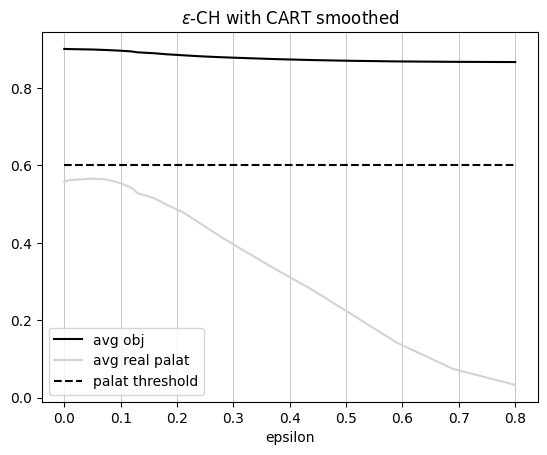

In [15]:
from scipy.ndimage.filters import gaussian_filter1d

mean_obj_smoothed = gaussian_filter1d(mean_obj, sigma=5)
mean_real_pal_smoothed = gaussian_filter1d(mean_real_pal, sigma=1)

plt.plot(epsilon, mean_obj_smoothed, color='black', label='avg obj')
plt.plot(epsilon, mean_real_pal_smoothed, color='lightgray', label='avg real palat')
plt.plot(epsilon, [lb]*len(epsilon), color='black', label='palat threshold', linestyle='--')
# plt.plot(epsilon, violations_pal, color='lightgray', label='% of violations', linestyle='-.')
plt.legend()
plt.gca().xaxis.grid(True, which='both', linewidth=0.5)
# plt.ylabel('average')
plt.xlabel('epsilon')
plt.title('$\epsilon$-CH with CART smoothed')
plt.show()

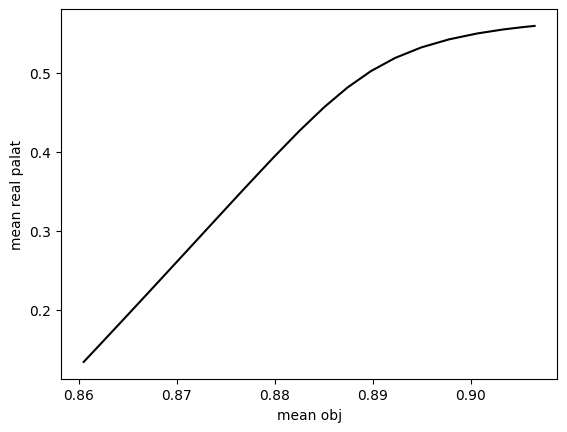

In [16]:
mean_obj_smoothed = gaussian_filter1d(mean_obj, sigma=3)
mean_real_pal_smoothed = gaussian_filter1d(mean_real_pal, sigma=3)

plt.plot(mean_obj_smoothed, mean_real_pal_smoothed, color='black')
plt.xlabel('mean obj')
plt.ylabel('mean real palat')
plt.show()

### Plot mean objective value and number of palatability constr violations wrt epsilon

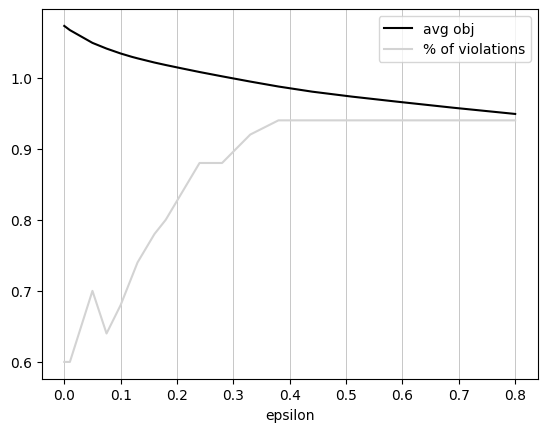

In [17]:
mean_obj = [np.mean([solution_info[i,j]['obj'] for j in range(M)]) for i in range(N)]
violations_pal = [np.sum([1 if solution_info[i,j]['real_pal'] < lb else 0 for j in range(M)])/M  for i in range(N)]

plt.plot(epsilon, mean_obj, color='black', label='avg obj')
plt.plot(epsilon, violations_pal, color='lightgray', label='% of violations')
plt.legend()
plt.gca().xaxis.grid(True, which='both', linewidth=0.5)
# plt.ylabel('average')
plt.xlabel('epsilon')
plt.show()

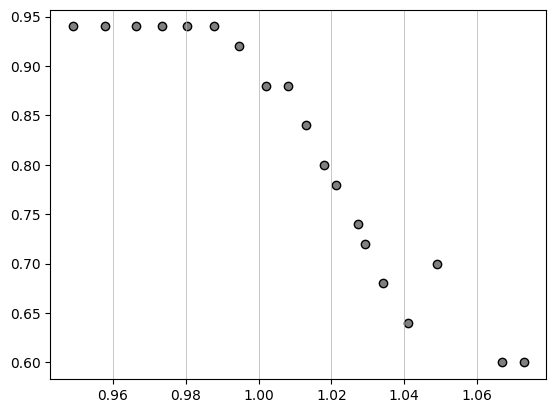

In [18]:
mean_obj = [np.mean([solution_info[i,j]['obj'] for j in range(M)]) for i in range(N)]
violations_pal = [np.sum([1 if solution_info[i,j]['real_pal'] < lb else 0 for j in range(M)])/M  for i in range(N)]

plt.scatter(mean_obj, violations_pal, color='gray', edgecolors='k')
plt.gca().xaxis.grid(True, which='both', linewidth=0.5)
plt.show()

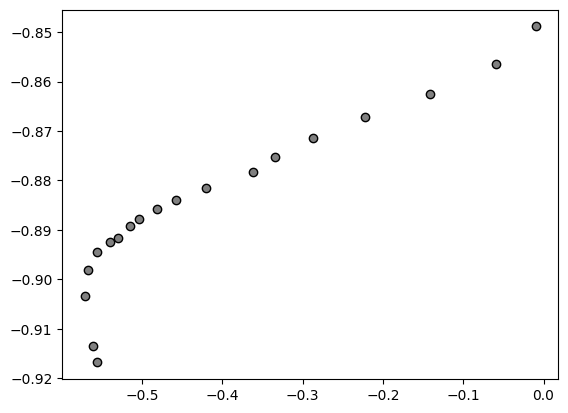

In [19]:
med_obj, med_pal = [np.median([solution_info[i,j]['obj'] for j in range(M)]) for i in range(N)],[np.median([solution_info[i,j]['real_pal'] for j in range(M)]) for i in range(N)]
plt.scatter(-np.array(med_pal), -np.array(med_obj), color='gray', edgecolors='k')
plt.show()